In [3]:
import argparse
import os

import mmcv
import torch
import numpy as np
from mmcv.parallel import MMDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

from mmedit.apis import multi_gpu_test, set_random_seed, single_gpu_test
from mmedit.core.distributed_wrapper import DistributedDataParallelWrapper
from mmedit.datasets import build_dataloader, build_dataset
from mmedit.models import build_model

import matplotlib.pyplot as plt 

In [72]:
def renorm(im, mean=127.5, std=127.5):
    return (im*std+mean).astype(int)
def tensor2image(t):
    return np.transpose(t.numpy(), (1,2,0))
def recover(im):
    return renorm(tensor2image(im))

In [19]:
config_name = "configs/inpainting/deepfillv2/deepfillv2_256x256_8x2_places.py"
cfg = mmcv.Config.fromfile(config_name)

In [20]:
dataset = build_dataset(cfg.data.test)

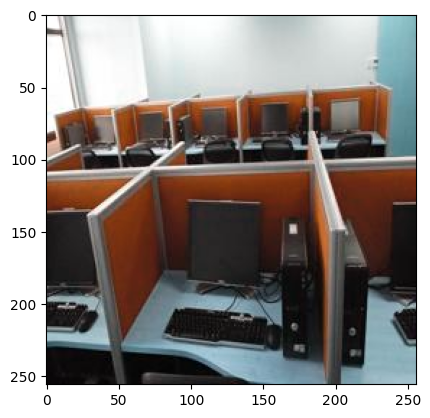

In [91]:
plt.figure()
plt.imshow(gt)
plt.show()

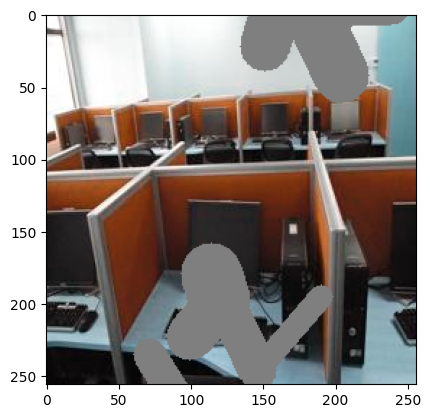

In [92]:
plt.figure()
plt.imshow(masked)
plt.show()

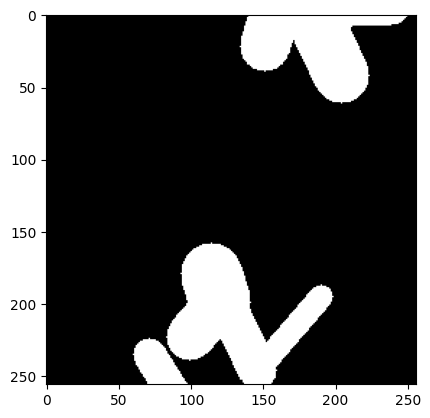

In [93]:
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

In [79]:
cfg.test_cfg.metrics = None
model = build_model(cfg.model, test_cfg=cfg.test_cfg)
_ = load_checkpoint(model, "models/deepfillv2_256x256_8x2_places_20200619-10d15793.pth", map_location='cpu')
model = MMDataParallel(model, device_ids=[0])
model.eval()
loader_cfg = {
    **dict((k, cfg.data[k]) for k in ['workers_per_gpu'] if k in cfg.data),
    **dict(
        samples_per_gpu=1,
        drop_last=False,
        shuffle=False,
        dist=False),
    **cfg.data.get('test_dataloader', {})
}

data_loader = build_dataloader(dataset, **loader_cfg)


Use load_from_local loader


In [98]:
peek = 100
_, gt, masked, mask = dataset[peek].values()
gt = recover(gt)
masked = recover(masked)
mask = recover(mask)
for i, data in enumerate(data_loader):
    if i == peek:
        with torch.no_grad():
            result = model(
                test_mode=True,
                **data)
        peek_data = data
        break

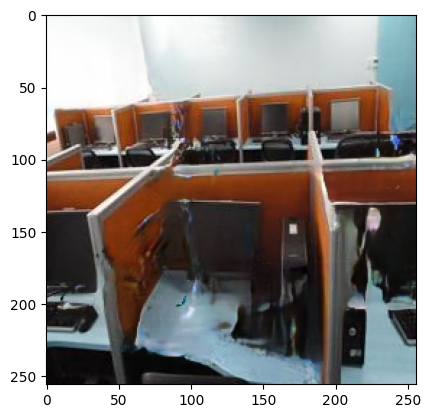

In [99]:
inpainted = recover(result['fake_img'][0].cpu())
plt.figure()
plt.imshow(inpainted)
plt.show()

In [104]:
mask = recover(peek_data['mask'][0])

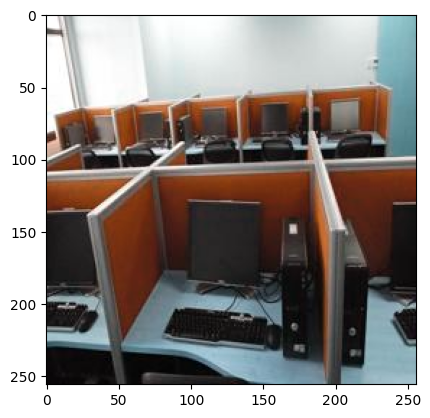

In [105]:
plt.figure()
plt.imshow(gt)
plt.show()

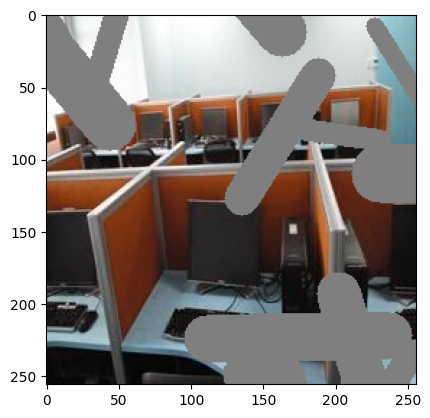

In [106]:
plt.figure()
plt.imshow(masked)
plt.show()

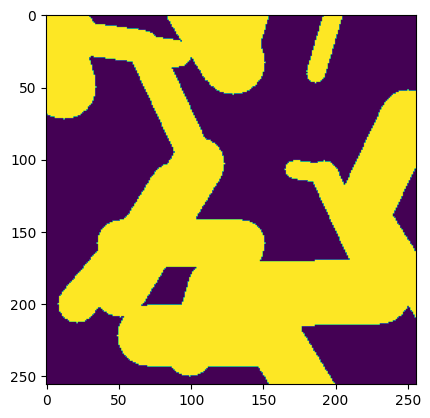

In [107]:
plt.figure()
plt.imshow(mask)
plt.show()

# File mask inpaint

In [16]:
import argparse
import numpy as np
import mmcv
import torch
import cv2
from mmedit.apis import init_model, inpainting_inference
from mmedit.core import tensor2img
import matplotlib.pyplot as plt 

In [13]:
config_name = "configs/inpainting/deepfillv2/deepfillv2_256x256_8x2_places.py"
ckpt_name = "models/deepfillv2_256x256_8x2_places_20200619-10d15793.pth"
img_path = "/home/wangk/mmsegmentation/demo/streetview_cars.png"
mask_path = "/home/wangk/mmsegmentation/demo/test_output/1car_250_500.png"

model = init_model(
    config_name, ckpt_name, device=torch.device('cuda:0'))

result = inpainting_inference(model, img_path, mask_path)
result = tensor2img(result, min_max=(-1, 1))[..., ::-1]


# mmcv.imshow(result, 'predicted inpainting result')


Use load_from_local loader


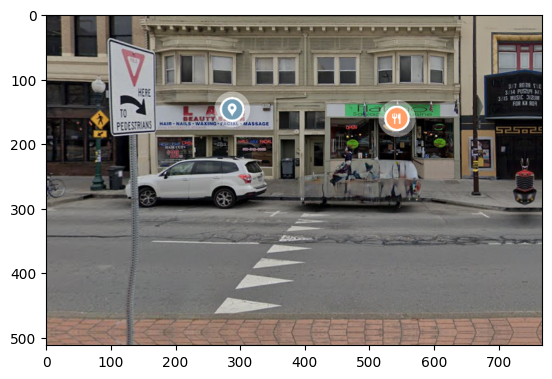

In [20]:
r = cv2.cvtColor(result.astype(np.uint8),cv2.COLOR_BGR2RGB)
plt.imshow(r)
plt.show()

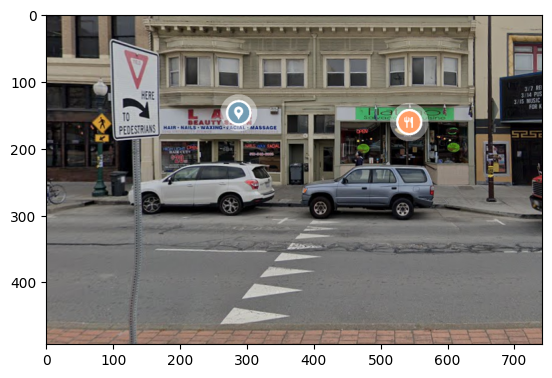

In [21]:
p = plt.imread(img_path)
plt.imshow(p)
plt.show()